In [ ]:
# load earth engine data
# load population data from worldpop for 2010, 2022
# run appropriate zonal stats
# compare population
# make graphics comparing the disribution
# do the same with HRSl as a range

In [1]:
import re
import time

import ee
import geemap
import geopandas as gpd
from google.cloud import storage

import sys
import os

sys.path.append(os.path.abspath(".."))  # Add the parent directory to Python path

In [2]:
BUCKET_NAME = "ciut-tablero"
GOOGLE_CLOUD_PROJECT = "ee-ciut"

In [3]:
ee.Authenticate()

ee.Initialize(project=GOOGLE_CLOUD_PROJECT)

In [4]:
target_partidos = ["La Plata", "Berisso", "Ensenada"]
gaul_l2 = ee.FeatureCollection("projects/sat-io/open-datasets/FAO/GAUL/GAUL_2024_L2")

municipalities = (
    gaul_l2.filter(ee.Filter.eq("gaul0_name", "Argentina"))
    .filter(ee.Filter.eq("gaul1_name", "Buenos Aires"))
    .filter(ee.Filter.inList("gaul2_name", target_partidos))
)

basins_gdf = gpd.read_file(
    "/home/nissim/Documents/dev/ciut-tablero/data/dipsoh_cuencas.geojson"
)
basins_ee = geemap.geopandas_to_ee(basins_gdf)
intersecting_basins = basins_ee.filterBounds(municipalities.geometry())
aoi = intersecting_basins.geometry()

In [7]:
aoi_gdf = geemap.ee_to_gdf(intersecting_basins)

In [9]:
pop_2020 = (
    ee.ImageCollection("WorldPop/GP/100m/pop")
    .filter(ee.Filter.eq("system:index", "ARG_2020"))
    .first()
    .clip(aoi)
)

pop_2010 = (
    ee.ImageCollection("WorldPop/GP/100m/pop")
    .filter(ee.Filter.eq("system:index", "ARG_2010"))
    .first()
    .clip(aoi)
)

In [10]:
# census_2010_gdf = gpd.read_file(
#     "/home/nissim/Documents/fulbright/Conicet digital 11336_149711/RADIOS_2010_V2025-1/Radios 2010 v2025-1.shp"
# )
# census_2010_gdf.to_parquet(
#     "/home/nissim/Documents/fulbright/Conicet digital 11336_149711/RADIOS_2010_V2025-1/Radios 2010 v2025-1.parquet"
# )

In [10]:
census_2010_gdf = gpd.read_parquet(
    "/home/nissim/Documents/fulbright/Conicet digital 11336_149711/RADIOS_2010_V2025-1/Radios 2010 v2025-1.parquet"
)

In [10]:
census_2010_gdf.columns

Index(['COD_2010', 'PROV', 'DEPTO', 'FRACC', 'RADIO', 'SEGMENTOS', 'OBS2010',
       'BASICO', 'AMPLIADO', 'TIPO', 'EXPH_MEAN', 'EXPH_MIN', 'EXPH_MAX',
       'B_POB_TOT', 'B_VIV_P', 'B_VIV_C', 'B_VIV_TOT', 'A_CASOS', 'A_POB_TOT',
       'A_VIV_P', 'A_VIV_C', 'A_VIV_TOT', 'D_AB_CASOS', 'D_AB_POB',
       'DP_AB_POB', 'geometry'],
      dtype='object')

In [14]:
import numpy as np

# Apply log(x+1) transformation to B_POB_TOT
census_2010_gdf['B_POB_TOT_log'] = np.log1p(census_2010_gdf['B_POB_TOT'])

<Axes: >

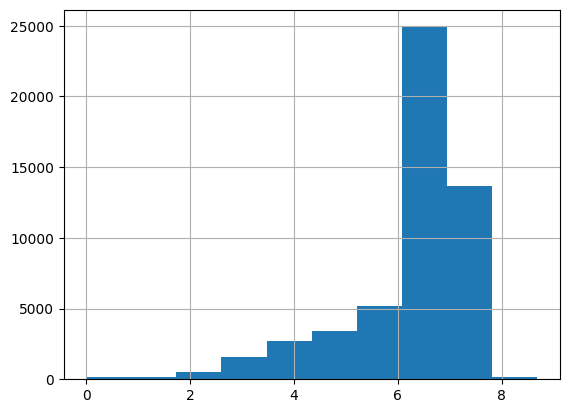

In [15]:
census_2010_gdf['B_POB_TOT_log'].hist()

In [11]:
# First ensure they're in the same projection
if census_2010_gdf.crs != aoi_gdf.crs:
    aoi_gdf = aoi_gdf.to_crs(census_2010_gdf.crs)

# Perform the spatial clip
clipped_census = gpd.clip(census_2010_gdf, aoi_gdf)
# First do the type conversions on the GeoDataFrame
clipped_census = clipped_census[['COD_2010', 'B_POB_TOT', 'geometry']]
clipped_census['COD_2010'] = clipped_census['COD_2010'].astype(str)
clipped_census['B_POB_TOT'] = clipped_census['B_POB_TOT'].astype(int)

# Then convert to Earth Engine
census_2010_ee = geemap.geopandas_to_ee(clipped_census)

In [15]:
# Create map and center on AOI
Map = geemap.Map(basemap="CartoDB.Positron")
Map.centerObject(aoi, 8)

Map.addLayer(
    pop_2010,
    {
        "bands": ["population"],
        "min": 0.0,
        "max": 50.0,
        "palette": ["24126c", "1fff4f", "d4ff50"],
    },
    "WorldPop Population (2010, 100m)",
    shown=False  # Start with layer off
)

vis_params = {
    "color": "000000",  # Black border
    "colorOpacity": 1,
    "width": 1,         # Thinner border for census tracts
    "lineType": "solid",
    "fillColorOpacity": 0.8,  # Slightly more opaque for better visibility
}

# Using a population-appropriate color palette (from low to high population)
palette = ["#f7fbff", "#deebf7", "#c6dbef", "#9ecae1", "#6baed6", "#4292c6", "#2171b5", "#08519c", "#08306b"]

Map.add_styled_vector(
    census_2010_ee,
    column="B_POB_TOT",
    palette=palette,
    layer_name="Censo 2010",
    **vis_params
)

In [16]:
Map

Map(center=[-35.23620217745599, -57.97610800815036], controls=(WidgetControl(options=['position', 'transparent…

In [ ]:
# quick zonal stats--sum 2010 population per census tract, calculate RMSE


In [17]:
out_census_stats = "census_stats.csv"
geemap.zonal_stats(pop_2010, census_2010_ee, out_census_stats, stat_type="SUM", scale=100)

Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to /home/nissim/Documents/dev/ciut-tablero/notebooks/census_stats.csv


In [19]:
import pandas as pd

In [20]:
df = pd.read_csv(out_census_stats)

In [21]:
df.head()

,sum,system:index,B_POB_TOT,COD_2010
0,137.003593,0,69,62170903
1,18.275361,1,72,62170904
2,62.014560,2,54,62170901
3,48.419660,3,85,62170801
4,34.682577,4,140,66550105


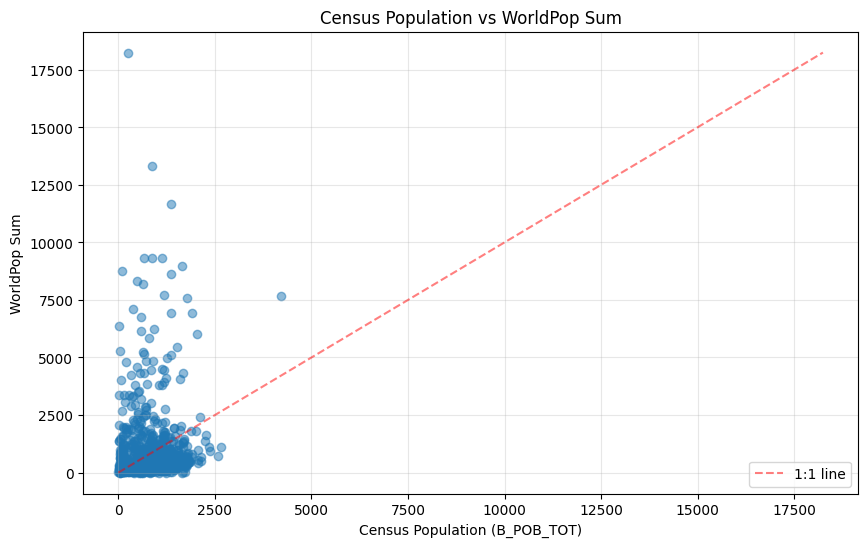

In [23]:
import matplotlib.pyplot as plt

# Create scatter plot comparing census population with WorldPop sum
plt.figure(figsize=(10, 6))
plt.scatter(df['B_POB_TOT'], df['sum'], alpha=0.5)
plt.xlabel('Census Population (B_POB_TOT)')
plt.ylabel('WorldPop Sum')
plt.title('Census Population vs WorldPop Sum')
plt.grid(True, alpha=0.3)

# Add a 1:1 line for reference
max_val = max(df['B_POB_TOT'].max(), df['sum'].max())
plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='1:1 line')
plt.legend()
plt.show()

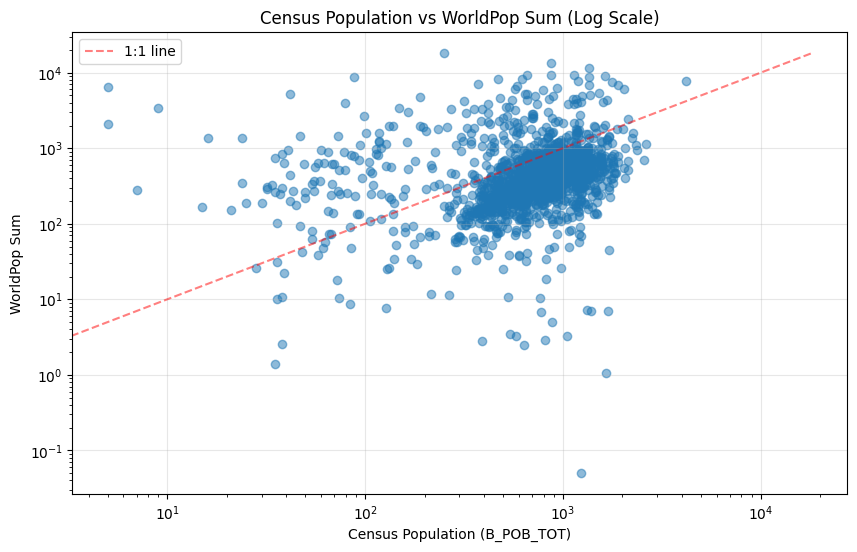

In [31]:
# Create log-scaled scatter plot comparing census population with WorldPop sum
plt.figure(figsize=(10, 6))
plt.scatter(df['B_POB_TOT'], df['sum'], alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Census Population (B_POB_TOT)')
plt.ylabel('WorldPop Sum')
plt.title('Census Population vs WorldPop Sum (Log Scale)')
plt.grid(True, alpha=0.3)

# Add a 1:1 line for reference
min_val = min(df['B_POB_TOT'].min(), df['sum'].min())
max_val = max(df['B_POB_TOT'].max(), df['sum'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5, label='1:1 line')
plt.legend()
plt.show()

In [33]:
from scipy import stats

# Calculate Pearson's correlation coefficient
correlation, p_value = stats.pearsonr(df['B_POB_TOT'], df['sum'])

print(f"Pearson's correlation coefficient: {correlation:.3f}")
print(f"p-value: {p_value:.3e}")

Pearson's correlation coefficient: 0.121
p-value: 1.266e-06


In [34]:
# Print basic statistics for both variables
print("Census Population (B_POB_TOT) statistics:")
print(df['B_POB_TOT'].describe())
print("\nWorldPop Sum statistics:")
print(df['sum'].describe())

# Calculate the ratio between WorldPop and Census
df['ratio'] = df['sum'] / df['B_POB_TOT']
print("\nRatio statistics (WorldPop/Census):")
print(df['ratio'].describe())

Census Population (B_POB_TOT) statistics:
count    1604.000000
mean      780.716958
std       420.307375
min         0.000000
25%       502.750000
50%       742.000000
75%      1019.500000
max      4218.000000
Name: B_POB_TOT, dtype: float64

WorldPop Sum statistics:
count     1604.000000
mean       696.877923
std       1215.006513
min          0.050228
25%        231.950088
50%        396.114550
75%        669.689775
max      18244.320764
Name: sum, dtype: float64

Ratio statistics (WorldPop/Census):
count    1604.000000
mean             inf
std              NaN
min         0.000041
25%         0.351745
50%         0.507214
75%         0.896300
max              inf
Name: ratio, dtype: float64


Ratio statistics (excluding zero population tracts):
count    1603.000000
mean        2.931473
std        35.210719
min         0.000041
25%         0.351739
50%         0.507160
75%         0.894771
max      1275.328254
Name: ratio, dtype: float64


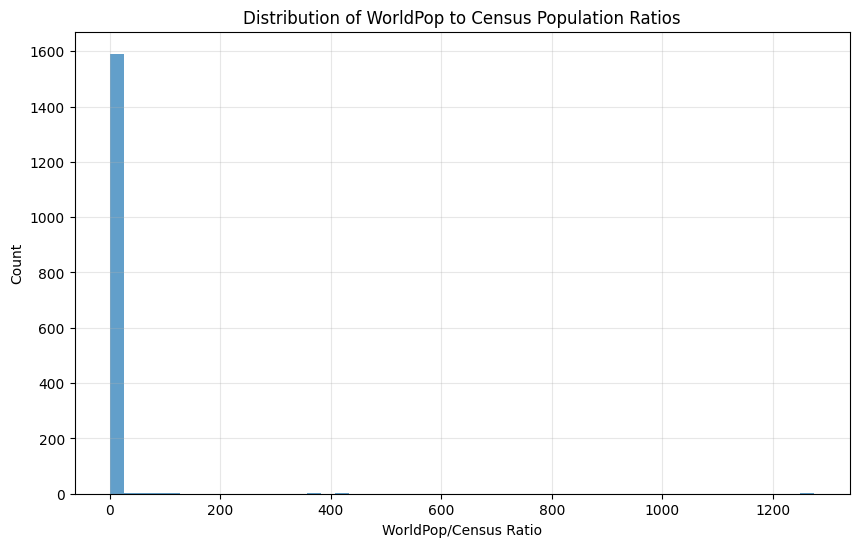

In [37]:
# Remove infinite values and look at ratio distribution
df_clean = df[df['B_POB_TOT'] > 0].copy()  # Remove zero population tracts
df_clean['ratio'] = df_clean['sum'] / df_clean['B_POB_TOT']

print("Ratio statistics (excluding zero population tracts):")
print(df_clean['ratio'].describe())

# Plot histogram of ratios
plt.figure(figsize=(10, 6))
plt.hist(df_clean['ratio'], bins=50, alpha=0.7)
plt.xlabel('WorldPop/Census Ratio')
plt.ylabel('Count')
plt.title('Distribution of WorldPop to Census Population Ratios')
plt.grid(True, alpha=0.3)
plt.show()

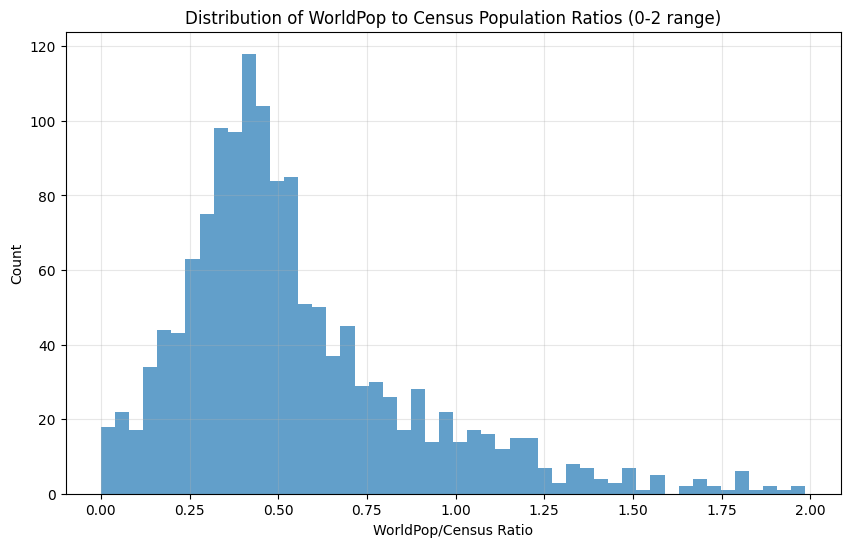


Percentage of tracts in different ratio ranges:
Ratio < 0.5: 49.2%
0.5 ≤ Ratio < 1.0: 29.0%
1.0 ≤ Ratio < 2.0: 9.5%
Ratio ≥ 2.0: 12.3%


In [38]:
# Plot histogram of ratios, focusing on the main distribution
plt.figure(figsize=(10, 6))
# Filter to ratios between 0 and 2 to see the main distribution
df_filtered = df_clean[df_clean['ratio'].between(0, 2)]
plt.hist(df_filtered['ratio'], bins=50, alpha=0.7)
plt.xlabel('WorldPop/Census Ratio')
plt.ylabel('Count')
plt.title('Distribution of WorldPop to Census Population Ratios (0-2 range)')
plt.grid(True, alpha=0.3)
plt.show()

# Print percentage of tracts in different ratio ranges
print("\nPercentage of tracts in different ratio ranges:")
print(f"Ratio < 0.5: {(df_clean['ratio'] < 0.5).mean()*100:.1f}%")
print(f"0.5 ≤ Ratio < 1.0: {(df_clean['ratio'].between(0.5, 1.0)).mean()*100:.1f}%")
print(f"1.0 ≤ Ratio < 2.0: {(df_clean['ratio'].between(1.0, 2.0)).mean()*100:.1f}%")
print(f"Ratio ≥ 2.0: {(df_clean['ratio'] >= 2.0).mean()*100:.1f}%")

In [25]:
import numpy as np

In [47]:
# Calculate absolute percentage error
df['abs_pct_error'] = abs(df['sum'] - df['B_POB_TOT']) / df['B_POB_TOT'].replace(0, np.nan) * 100

# Calculate signed percentage error (positive = overestimation, negative = underestimation)
df['signed_pct_error'] = (df['sum'] - df['B_POB_TOT']) / df['B_POB_TOT'].replace(0, np.nan) * 100

# Print some statistics
print("Absolute Percentage Error Statistics:")
print(df['abs_pct_error'].describe())
print("\nSigned Percentage Error Statistics:")
print(df['signed_pct_error'].describe())

Absolute Percentage Error Statistics:
count      1603.000000
mean        277.808215
std        3515.401926
min           0.089270
25%          39.424638
50%          57.932656
75%          75.359054
max      127432.825431
Name: abs_pct_error, dtype: float64

Signed Percentage Error Statistics:
count      1603.000000
mean        193.147303
std        3521.071870
min         -99.995923
25%         -64.826098
50%         -49.283982
75%         -10.522886
max      127432.825431
Name: signed_pct_error, dtype: float64


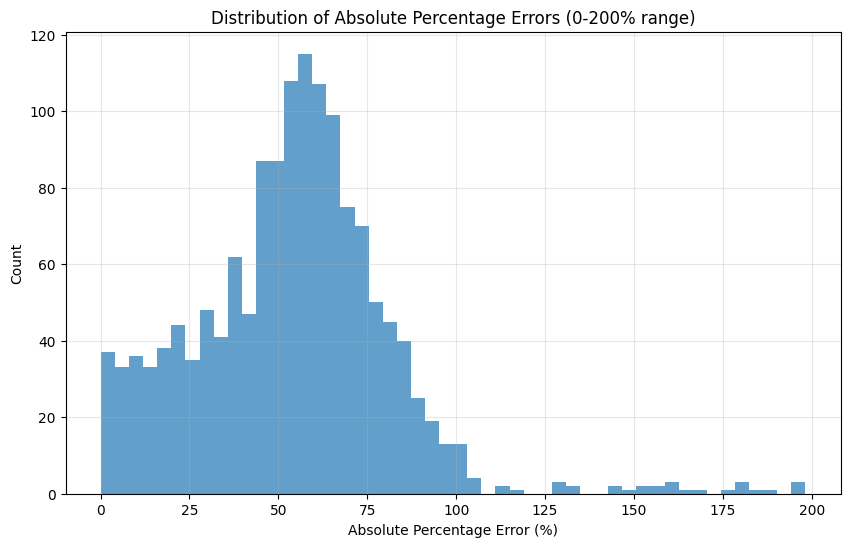


Percentage of tracts in different error ranges:
Error < 25%: 14.5%
25% ≤ Error < 50%: 22.3%
50% ≤ Error < 100%: 50.9%
Error ≥ 100%: 12.3%


In [48]:
# Plot histogram of absolute percentage errors, focusing on the main distribution
plt.figure(figsize=(10, 6))
# Filter to errors between 0 and 200% to see the main distribution
df_filtered = df[df['abs_pct_error'].between(0, 200)]
plt.hist(df_filtered['abs_pct_error'], bins=50, alpha=0.7)
plt.xlabel('Absolute Percentage Error (%)')
plt.ylabel('Count')
plt.title('Distribution of Absolute Percentage Errors (0-200% range)')
plt.grid(True, alpha=0.3)
plt.show()

# Print percentage of tracts in different error ranges
print("\nPercentage of tracts in different error ranges:")
print(f"Error < 25%: {(df['abs_pct_error'] < 25).mean()*100:.1f}%")
print(f"25% ≤ Error < 50%: {(df['abs_pct_error'].between(25, 50)).mean()*100:.1f}%")
print(f"50% ≤ Error < 100%: {(df['abs_pct_error'].between(50, 100)).mean()*100:.1f}%")
print(f"Error ≥ 100%: {(df['abs_pct_error'] >= 100).mean()*100:.1f}%")

In [44]:
df.head()

,sum,system:index,B_POB_TOT,COD_2010,abs_error,rmse,ratio,pct_error
0,137.003593,0,69,62170903,68.003593,639.686486,1.985559,0.971480
1,18.275361,1,72,62170904,-53.724639,639.686486,0.253824,-0.735954
2,62.014560,2,54,62170901,8.014560,639.686486,1.148418,0.145719
3,48.419660,3,85,62170801,-36.580340,639.686486,0.569643,-0.425353
4,34.682577,4,140,66550105,-105.317423,639.686486,0.247733,-0.746932


<Axes: >

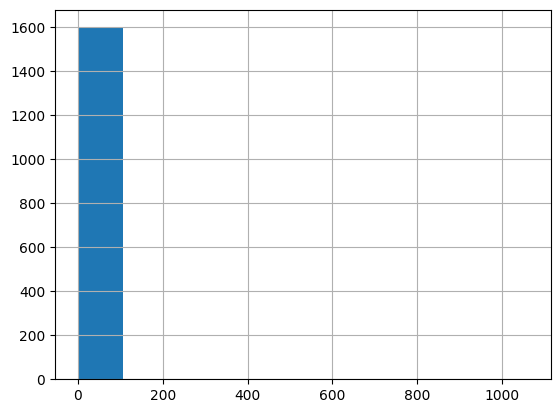

In [45]:
df['pct_error'].hist()

In [46]:
df['pct_error'].describe()

count    1604.000000
mean        1.724369
std        29.656867
min        -0.999148
25%        -0.646287
50%        -0.492107
75%        -0.103536
max      1061.940212
Name: pct_error, dtype: float64